In [ ]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
os.chdir("drive/")
os.chdir('My Drive')
os.chdir('Experiment')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [ ]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print(f'Using PyTorch version: {torch.__version__}, Device: {DEVICE}')

Using PyTorch version: 1.11.0+cu113, Device: cuda


In [ ]:
BATCH_SIZE = 32
EPOCHS = 10

# Data Loading

In [ ]:
!mkdir data

train_dataset = datasets.FashionMNIST(root='./data/FashionMNIST', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.FashionMNIST(root='./data/FashionMNIST', train=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



In [ ]:
for (X_train, y_train) in train_loader:
    print(f'X_train: {X_train.size()}, type: {X_train.type()}')
    print(f'y_train: {y_train.size()}, type: {y_train.type()}')
    break

X_train: torch.Size([32, 1, 28, 28]), type: torch.FloatTensor
y_train: torch.Size([32]), type: torch.LongTensor


# Model

In [ ]:
class AE(nn.Module):
    def __init__(self) -> None:
        super(AE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 32)
        )

        self.decoder = nn.Sequential(
            nn.Linear(32, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28)
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return encoded, decoded

In [ ]:
model = AE().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

print(model)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)


In [ ]:
def train(model, train_loader, optimizer, log_interval, epoch):
    model.train()
    for batch_idx, (image, _) in enumerate(train_loader):
        # forward propagation
        image = image.view(-1, 28 * 28).to(DEVICE)
        target = image.view(-1, 28 * 28).to(DEVICE)
        optimizer.zero_grad()
        encoded, decoded = model(image)

        # backward propagation
        loss = criterion(decoded, target)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print('train epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}'.format(epoch, batch_idx * len(image), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))

In [ ]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    real_image, gen_image = [], []
    with torch.no_grad():
        for image, _ in test_loader:
            image = image.view(-1, 28 * 28).to(DEVICE)
            target = image.view(-1, 28 * 28).to(DEVICE)
            encoded, decoded = model(image)

            test_loss += criterion(decoded, image).item()
            real_image.append(image.to('cpu'))
            gen_image.append(decoded.to('cpu'))
    test_loss /= len(test_loader.dataset)
    return test_loss, real_image, gen_image

train epoch: 1 [0/60000(0%)]	Train Loss: 0.015630
train epoch: 1 [6400/60000(11%)]	Train Loss: 0.012233
train epoch: 1 [12800/60000(21%)]	Train Loss: 0.012282
train epoch: 1 [19200/60000(32%)]	Train Loss: 0.011247
train epoch: 1 [25600/60000(43%)]	Train Loss: 0.012504
train epoch: 1 [32000/60000(53%)]	Train Loss: 0.014741
train epoch: 1 [38400/60000(64%)]	Train Loss: 0.012927
train epoch: 1 [44800/60000(75%)]	Train Loss: 0.012451
train epoch: 1 [51200/60000(85%)]	Train Loss: 0.014028
train epoch: 1 [57600/60000(96%)]	Train Loss: 0.014703

[EPOCH: 1], 	Test Loss: 0.0004


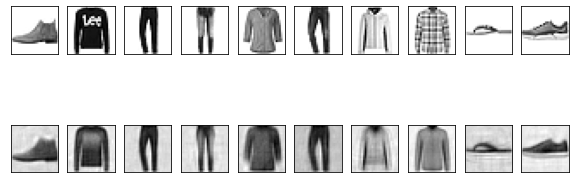

train epoch: 2 [0/60000(0%)]	Train Loss: 0.013190
train epoch: 2 [6400/60000(11%)]	Train Loss: 0.012156
train epoch: 2 [12800/60000(21%)]	Train Loss: 0.010261
train epoch: 2 [19200/60000(32%)]	Train Loss: 0.015064
train epoch: 2 [25600/60000(43%)]	Train Loss: 0.010549
train epoch: 2 [32000/60000(53%)]	Train Loss: 0.010703
train epoch: 2 [38400/60000(64%)]	Train Loss: 0.015331
train epoch: 2 [44800/60000(75%)]	Train Loss: 0.011545
train epoch: 2 [51200/60000(85%)]	Train Loss: 0.015585
train epoch: 2 [57600/60000(96%)]	Train Loss: 0.009901

[EPOCH: 2], 	Test Loss: 0.0004


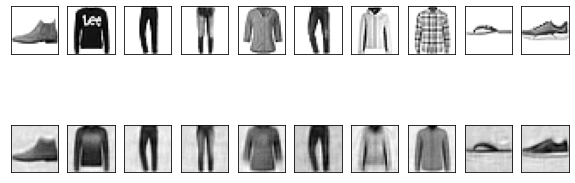

train epoch: 3 [0/60000(0%)]	Train Loss: 0.012405
train epoch: 3 [6400/60000(11%)]	Train Loss: 0.012914
train epoch: 3 [12800/60000(21%)]	Train Loss: 0.013875
train epoch: 3 [19200/60000(32%)]	Train Loss: 0.010009
train epoch: 3 [25600/60000(43%)]	Train Loss: 0.013126
train epoch: 3 [32000/60000(53%)]	Train Loss: 0.012304
train epoch: 3 [38400/60000(64%)]	Train Loss: 0.010633
train epoch: 3 [44800/60000(75%)]	Train Loss: 0.010446
train epoch: 3 [51200/60000(85%)]	Train Loss: 0.010693
train epoch: 3 [57600/60000(96%)]	Train Loss: 0.009421

[EPOCH: 3], 	Test Loss: 0.0003


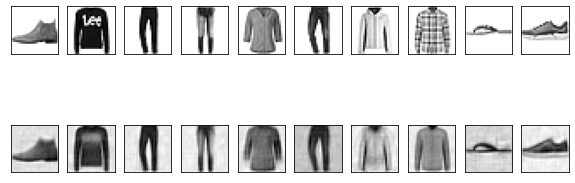

train epoch: 4 [0/60000(0%)]	Train Loss: 0.011581
train epoch: 4 [6400/60000(11%)]	Train Loss: 0.010059
train epoch: 4 [12800/60000(21%)]	Train Loss: 0.009477
train epoch: 4 [19200/60000(32%)]	Train Loss: 0.012576
train epoch: 4 [25600/60000(43%)]	Train Loss: 0.010576
train epoch: 4 [32000/60000(53%)]	Train Loss: 0.013878
train epoch: 4 [38400/60000(64%)]	Train Loss: 0.008094
train epoch: 4 [44800/60000(75%)]	Train Loss: 0.009542
train epoch: 4 [51200/60000(85%)]	Train Loss: 0.010237
train epoch: 4 [57600/60000(96%)]	Train Loss: 0.012656

[EPOCH: 4], 	Test Loss: 0.0003


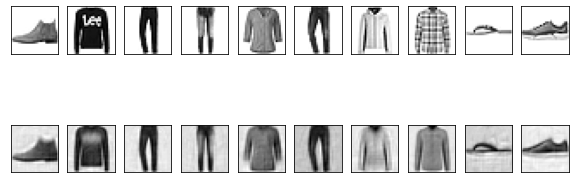

train epoch: 5 [0/60000(0%)]	Train Loss: 0.011074
train epoch: 5 [6400/60000(11%)]	Train Loss: 0.009593
train epoch: 5 [12800/60000(21%)]	Train Loss: 0.011896
train epoch: 5 [19200/60000(32%)]	Train Loss: 0.010053
train epoch: 5 [25600/60000(43%)]	Train Loss: 0.012370
train epoch: 5 [32000/60000(53%)]	Train Loss: 0.011718
train epoch: 5 [38400/60000(64%)]	Train Loss: 0.008621
train epoch: 5 [44800/60000(75%)]	Train Loss: 0.009962
train epoch: 5 [51200/60000(85%)]	Train Loss: 0.010210
train epoch: 5 [57600/60000(96%)]	Train Loss: 0.007727

[EPOCH: 5], 	Test Loss: 0.0003


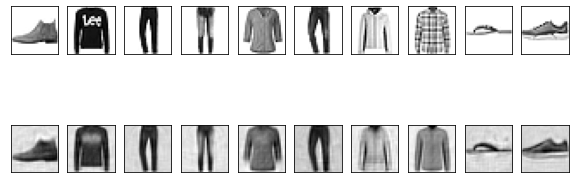

train epoch: 6 [0/60000(0%)]	Train Loss: 0.010372
train epoch: 6 [6400/60000(11%)]	Train Loss: 0.009858
train epoch: 6 [12800/60000(21%)]	Train Loss: 0.010164
train epoch: 6 [19200/60000(32%)]	Train Loss: 0.008753
train epoch: 6 [25600/60000(43%)]	Train Loss: 0.009713
train epoch: 6 [32000/60000(53%)]	Train Loss: 0.010515
train epoch: 6 [38400/60000(64%)]	Train Loss: 0.008750
train epoch: 6 [44800/60000(75%)]	Train Loss: 0.009615
train epoch: 6 [51200/60000(85%)]	Train Loss: 0.010876
train epoch: 6 [57600/60000(96%)]	Train Loss: 0.009425

[EPOCH: 6], 	Test Loss: 0.0003


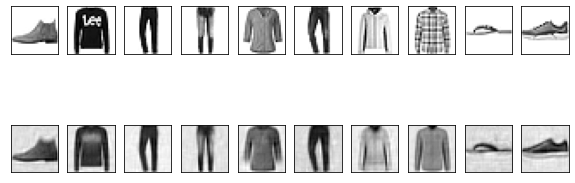

train epoch: 7 [0/60000(0%)]	Train Loss: 0.009374
train epoch: 7 [6400/60000(11%)]	Train Loss: 0.010608
train epoch: 7 [12800/60000(21%)]	Train Loss: 0.010814
train epoch: 7 [19200/60000(32%)]	Train Loss: 0.009760
train epoch: 7 [25600/60000(43%)]	Train Loss: 0.009434
train epoch: 7 [32000/60000(53%)]	Train Loss: 0.012372
train epoch: 7 [38400/60000(64%)]	Train Loss: 0.010116
train epoch: 7 [44800/60000(75%)]	Train Loss: 0.010996
train epoch: 7 [51200/60000(85%)]	Train Loss: 0.009754
train epoch: 7 [57600/60000(96%)]	Train Loss: 0.012459

[EPOCH: 7], 	Test Loss: 0.0003


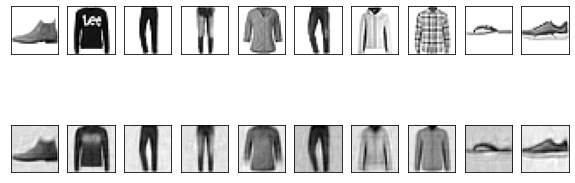

train epoch: 8 [0/60000(0%)]	Train Loss: 0.009427
train epoch: 8 [6400/60000(11%)]	Train Loss: 0.012950
train epoch: 8 [12800/60000(21%)]	Train Loss: 0.012286
train epoch: 8 [19200/60000(32%)]	Train Loss: 0.011924
train epoch: 8 [25600/60000(43%)]	Train Loss: 0.010184
train epoch: 8 [32000/60000(53%)]	Train Loss: 0.010107
train epoch: 8 [38400/60000(64%)]	Train Loss: 0.010422
train epoch: 8 [44800/60000(75%)]	Train Loss: 0.009009
train epoch: 8 [51200/60000(85%)]	Train Loss: 0.008758
train epoch: 8 [57600/60000(96%)]	Train Loss: 0.009781

[EPOCH: 8], 	Test Loss: 0.0003


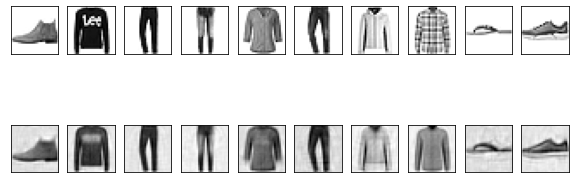

train epoch: 9 [0/60000(0%)]	Train Loss: 0.009539
train epoch: 9 [6400/60000(11%)]	Train Loss: 0.009279
train epoch: 9 [12800/60000(21%)]	Train Loss: 0.009597
train epoch: 9 [19200/60000(32%)]	Train Loss: 0.009389
train epoch: 9 [25600/60000(43%)]	Train Loss: 0.008883
train epoch: 9 [32000/60000(53%)]	Train Loss: 0.011108
train epoch: 9 [38400/60000(64%)]	Train Loss: 0.010461
train epoch: 9 [44800/60000(75%)]	Train Loss: 0.010728
train epoch: 9 [51200/60000(85%)]	Train Loss: 0.009786
train epoch: 9 [57600/60000(96%)]	Train Loss: 0.009985

[EPOCH: 9], 	Test Loss: 0.0003


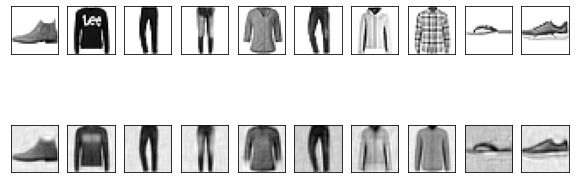

train epoch: 10 [0/60000(0%)]	Train Loss: 0.007700
train epoch: 10 [6400/60000(11%)]	Train Loss: 0.010033
train epoch: 10 [12800/60000(21%)]	Train Loss: 0.010283
train epoch: 10 [19200/60000(32%)]	Train Loss: 0.009206
train epoch: 10 [25600/60000(43%)]	Train Loss: 0.009050
train epoch: 10 [32000/60000(53%)]	Train Loss: 0.008953
train epoch: 10 [38400/60000(64%)]	Train Loss: 0.009943
train epoch: 10 [44800/60000(75%)]	Train Loss: 0.009986
train epoch: 10 [51200/60000(85%)]	Train Loss: 0.009176
train epoch: 10 [57600/60000(96%)]	Train Loss: 0.009624

[EPOCH: 10], 	Test Loss: 0.0003


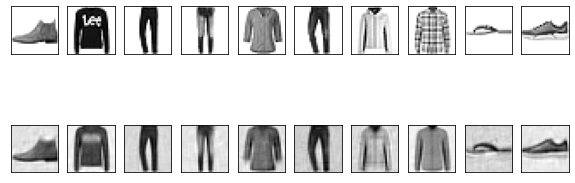

In [ ]:
epoch_max = EPOCHS + 1
for epoch in range(1, epoch_max):
    train(model, train_loader, optimizer, log_interval=200, epoch=epoch)
    test_loss, real_image, gen_image = evaluate(model, test_loader)

    print('\n[EPOCH: {}], \tTest Loss: {:.4f}'.format(epoch, test_loss))
    f, a = plt.subplots(2, 10, figsize=(10, 4))
    num_of_imgs = 10
    for i in range(num_of_imgs):
        img1 = np.reshape(real_image[0][i], (28, 28))
        a[0][i].imshow(img1, cmap='gray_r')
        a[0][i].set_xticks(( ))
        a[0][i].set_yticks(( ))

        img2 = np.reshape(gen_image[0][i], (28, 28))
        a[1][i].imshow(img2, cmap='gray_r')
        a[1][i].set_xticks(( ))
        a[1][i].set_yticks(( ))
    plt.show()